# PINT

(credit: [PINT documentation](https://nanograv-pint.readthedocs.io/en/latest/))

PINT (Pint is not tempo3) is a Python package designed for producing timing solution. It is independent of other timing software like tempo and tempo2.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

import pint.fitter
from pint.models import get_model_and_toas
from pint.residuals import Residuals
from pint.toa import get_TOAs
import pint.logging

pint.logging.setup(level="INFO")

1

To familiarize ourselves with the PINT framework, we will work with the example pulsar that is provided with the PINT installation.

In [2]:
#Use internally provided dataset

import pint.config

parfile = pint.config.examplefile("NGC6440E.par")
timfile = pint.config.examplefile("NGC6440E.tim")

In [3]:
#Load in the timing model from the parfile and TOAs from the timfile

m, t_all = get_model_and_toas(parfile, timfile)

WARNING  (pint.logging                  ): /opt/conda/lib/python3.9/site-packages/pint/models/timing_model.py:375 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.toa                      ): CLOCK = UTC(NIST) is not implemented. Using TT(BIPM2021) instead.
WARNING  (pint.toa                      ): Unknown command MODE in line MODE 1

INFO     (pint.observatory.global_clock_corrections): File index.txt to be downloaded due to download policy if_expired: https://raw.githubusercontent.com/ipta/pulsar-clock-corrections/main/index.txt
INFO     (pint.observatory.topo_obs     ): Using global clock file for time_gbt.dat
INFO     (pint.observatory.topo_obs     ): Applying observatory clock corrections.
INFO     (pint.observatory.topo_obs     ): Applying GPS to UTC clock correction (~few nanoseconds)
INFO     (pint.observatory.topo_obs     ): Loading global GPS clock file for gbt
INFO     (pint.observatory.topo_obs     ): Using global clock file for gps2utc.clk
INFO     (pint

In [4]:
m

TimingModel(
  AbsPhase(
    MJDParameter(   TZRMJD              53801.3860512007484954 (d) frozen=True),
    strParameter(   TZRSITE             1                 frozen=True),
    floatParameter( TZRFRQ              1949.609          (MHz) frozen=True)),
  AstrometryEquatorial(
    MJDParameter(   POSEPOCH            53750.0000000000000000 (d) frozen=True),
    floatParameter( PX                  0.0               (mas) frozen=True),
    AngleParameter( RAJ                 17:48:52.75000000 (hourangle) +/- 0h00m00.05s frozen=False),
    AngleParameter( DECJ                -20:21:29.00000000 (deg) +/- 0d00m00.4s frozen=False),
    floatParameter( PMRA                0.0               (mas / yr) frozen=True),
    floatParameter( PMDEC               0.0               (mas / yr) frozen=True)),
  DispersionDM(
    floatParameter( DM                  223.9             (pc / cm3) +/- 0.3 pc / cm3 frozen=False),
    floatParameter( DM1                 UNSET,
    MJDParameter(   DMEPOCH      

In [5]:
t_all.print_summary()

Number of TOAs:  62
Number of commands:  1
Number of observatories: 1 ['gbt']
MJD span:  53478.286 to 54187.587
Date span: 2005-04-18 06:51:39.290648106 to 2007-03-28 14:05:44.808308037
gbt TOAs (62):
  Min freq:      1549.609 MHz
  Max freq:      2212.109 MHz
  Min error:     13.2 us
  Max error:     118 us
  Median error:  22.1 us



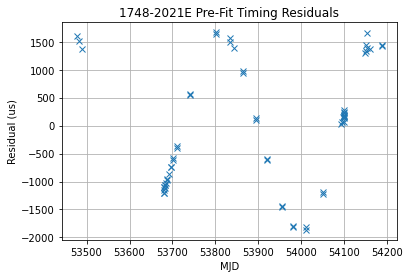

In [6]:
#Calculate the pre-fit residuals
rs = Residuals(t_all, m)
xt = rs.toas.get_mjds()

plt.figure()
plt.plot(xt, rs.time_resids.to(u.us), "x")
plt.title("%s Pre-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [7]:
#As an example, we want to excise all data with errors greater than 30 us
error_ok = t_all.table["error"] <= 30 * u.us
t = t_all[error_ok]
t.print_summary()

Number of TOAs:  44
Number of commands:  1
Number of observatories: 1 ['gbt']
MJD span:  53478.286 to 54187.587
Date span: 2005-04-18 06:51:39.290648106 to 2007-03-28 14:05:44.808308037
gbt TOAs (44):
  Min freq:      1724.609 MHz
  Max freq:      1949.609 MHz
  Min error:     13.2 us
  Max error:     29.9 us
  Median error:  21.5 us



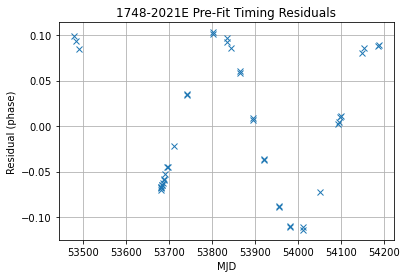

In [8]:
#Plot residuals after excision
rs = Residuals(t, m).phase_resids
xt = t.get_mjds()

plt.figure()
plt.plot(xt, rs, "x")
plt.title("%s Pre-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (phase)")
plt.grid()

In [9]:
#Fit the timing model to the TOAs
#Let PINT figure out which fitter to use.
#Many fitters available in PINT.

f = pint.fitter.Fitter.auto(t, m)
f.fit_toas()

INFO     (pint.fitter                   ): For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


In [10]:
# Print some basic params
print("Best fit has reduced chi^2 of", f.resids.chi2_reduced)
print("RMS in phase is", f.resids.phase_resids.std())
print("RMS in time is", f.resids.time_resids.std().to(u.us))

Best fit has reduced chi^2 of 1.036739834237582775
RMS in phase is 0.0011179200258477613
RMS in time is 18.181855110332737 us


In [11]:
f.print_summary()

Fitted model using downhill_wls method with 5 free parameters to 44 TOAs
Prefit residuals Wrms = 1113.6432901099379 us, Postfit residuals Wrms = 18.175665163117117 us
Chisq = 39.396 for 38 d.o.f. for reduced Chisq of 1.037

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2021E 1748-2021E                   None
EPHEM                              DE421 DE421                        None
CLOCK                          UTC(NIST) TT(BIPM2021)                 None
UNITS                                TDB TDB                          None
START                                                         53478.3 d 
FINISH                                                        54187.6 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ                  

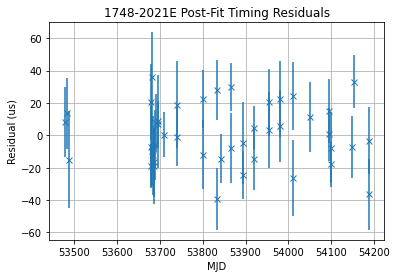

In [12]:
plt.figure()
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.us).value,
    t.get_errors().to(u.us).value,
    fmt="x",
)
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

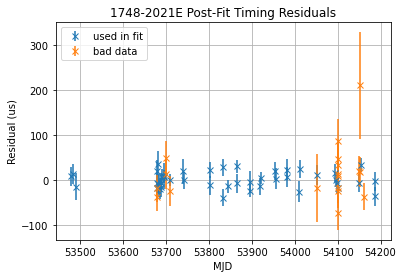

In [13]:
t_bad = t_all[~error_ok]
r_bad = Residuals(t_bad, f.model)
plt.figure()
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.us).value,
    t.get_errors().to(u.us).value,
    fmt="x",
    label="used in fit",
)
plt.errorbar(
    t_bad.get_mjds().value,
    r_bad.time_resids.to(u.us).value,
    t_bad.get_errors().to(u.us).value,
    fmt="x",
    label="bad data",
)
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()
plt.legend(loc="upper left")

In [14]:
print(f.model.as_parfile())

# Created: 2022-07-11T21:35:17.708663
# PINT_version: 0.9.0
# User: jovyan
# Host: 8c04a9de1003
# OS: Linux-4.18.0-348.20.1.el8_5.x86_64-x86_64-with-glibc2.31
# Format: pint
PSR                            1748-2021E
EPHEM                               DE421
CLK                          TT(BIPM2021)
UNITS                                 TDB
START              53478.2858714195382639
FINISH             54187.5873241702319097
TIMEEPH                              FB90
T2CMETHOD                        IAU2000B
DILATEFREQ                              N
DMDATA                                  N
NTOA                                   44
CHI2                                  0.0
RAJ                     17:48:52.80032123 1 0.00013868970124516564
DECJ                   -20:21:29.39582206 1 0.03403292479977475943
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
POSEPOCH           53750.0000000000000000
F0                  

### Creating a timing model from scratch

Since PINT is a pure Python construct, the timing model construction can be broken down in the following steps:

1. Create an instance of the TimingModel class.
2. Choose and add Components to the TimingModel class.
3. Set the values of the Parameters in the Components.
4. Setup and validate the TimingModel.
5. Fit!
6. Collect new data (i.e. TOAs) and go to 2.



In [15]:
import astropy.units as u  # Astropy units is a very useful module.
import pint.logging

# setup logging
pint.logging.setup(level="INFO")
from pint.models import (
    parameter as p,
)  # We would like to add parameters to the model, so we need parameter module.
from pint.models.timing_model import (
    TimingModel,
    Component,
)  # Interface for timing model
import pint
from astropy.time import Time  # PINT uses astropy Time objects to represent times

In [16]:
# list all the existing components
# all_components is a dictionary, with the component name as the key and component class as the value.
all_components = Component.component_types
# Print the component class names.
_ = [print(x) for x in all_components]  # The "_ =" just suppresses excess output

AbsPhase
AstrometryEquatorial
AstrometryEcliptic
BinaryBT
BinaryDD
BinaryDDK
BinaryELL1
BinaryELL1H
DispersionDM
DispersionDMX
DispersionJump
FD
Glitch
PiecewiseSpindown
IFunc
PhaseJump
ScaleToaError
ScaleDmError
EcorrNoise
PLRedNoise
SolarSystemShapiro
SolarWindDispersion
Spindown
TroposphereDelay
Wave


In [17]:
selected_components = ["AbsPhase", "AstrometryEquatorial", "Spindown"]
component_instances = []

# Initiate the component instances
for cp_name in selected_components:
    component_class = all_components[cp_name]  # Get the component class
    component_instance = component_class()  # Instantiate a component object
    component_instances.append(component_instance)

In [18]:
# Construct timing model instance, given a name and a list of components to include (that we just created above)
tm = TimingModel("NGC6400E", component_instances)

In [19]:
# print the components in the timing model
for (cp_name, cp_instance) in tm.components.items():
    print(cp_name, cp_instance)

AbsPhase AbsPhase(
    MJDParameter(   TZRMJD              UNSET,
    strParameter(   TZRSITE             UNSET,
    floatParameter( TZRFRQ              UNSET)
Spindown Spindown(
    floatParameter( F0                  0.0               (Hz) frozen=True),
    MJDParameter(   PEPOCH              UNSET)
AstrometryEquatorial AstrometryEquatorial(
    MJDParameter(   POSEPOCH            UNSET,
    floatParameter( PX                  0.0               (mas) frozen=True),
    AngleParameter( RAJ                 UNSET,
    AngleParameter( DECJ                UNSET,
    floatParameter( PMRA                0.0               (mas / yr) frozen=True),
    floatParameter( PMDEC               0.0               (mas / yr) frozen=True))


In [20]:
# We build a dictionary with a key for each parameter we want to set.
# The dictionary entries can be either
#  {'pulsar name': (parameter value, TEMPO_Fit_flag, uncertainty)} akin to a TEMPO par file form
# or
# {'pulsar name': (parameter value, )} for parameters that can't be fit
# NOTE: The values here are assumed to be in the default units for each parameter
# Notice that we assign values with units, and pint defines a special hourangle_second unit that can be use for
# right ascensions.  Also, angles can be specified as strings that will be parsed by astropy.
params = {
    "PSR": ("1748-2021E",),
    "RAJ": ("17:48:52.75", 1, 0.05 * pint.hourangle_second),
    "DECJ": ("-20:21:29.0", 1, 0.4 * u.arcsec),
    "F0": (61.585476554 * u.Hz, 1, 5e-10 * u.Hz),
    "PEPOCH": (Time(53750.000000, format="mjd", scale="tdb"),),
    "POSEPOCH": (Time(53750.000000, format="mjd", scale="tdb"),),
    "TZRMJD": (Time(53801.38605120074849, format="mjd", scale="tdb"),),
    "TZRFRQ": (1949.609 * u.MHz,),
    "TZRSITE": (1,),
}

# Assign the parameters
for name, info in params.items():
    par = getattr(tm, name)  # Get parameter object from name
    par.quantity = info[0]  # set parameter value
    if len(info) > 1:
        if info[1] == 1:
            par.frozen = False  # Frozen means not fit.
        par.uncertainty = info[2]

In [21]:
tm.setup()
tm.validate()
# You should see all the assigned parameters.
# Printing a TimingModel object shows the parfile representation
print(tm)

# Created: 2022-07-11T21:35:17.779955
# PINT_version: 0.9.0
# User: jovyan
# Host: 8c04a9de1003
# OS: Linux-4.18.0-348.20.1.el8_5.x86_64-x86_64-with-glibc2.31
# Format: pint
PSR                            1748-2021E
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
CHI2                                  0.0
RAJ                     17:48:52.75000000 1 0.04999999999999999584
DECJ                   -20:21:29.00000000 1 0.40000000000000002220
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
POSEPOCH           53750.0000000000000000
F0                   61.58547655400000309 1 5.0000000000000003114e-10
PEPOCH             53750.0000000000000000
TZRMJD             53801.3860512007449870
TZRSITE                                 1
TZRFRQ                           1949.609



In [22]:
dispersion_class = all_components["DispersionDM"]
dispersion = dispersion_class()  # Make the dispersion instance.

# Using validate=False here allows a component being added first and validate later.
tm.add_component(dispersion, validate=False)

In [23]:
# print the components out, DispersionDM should be there.
print("All components in timing model:")
display(tm.components)

print("\n")
print("Delay components in the DelayComponent_list (order matters!):")

# print the delay component order, dispersion should be after the astrometry
display(tm.DelayComponent_list)

All components in timing model:


{'AbsPhase': AbsPhase(
     MJDParameter(   TZRMJD              53801.3860512007449870 (d) frozen=True),
     strParameter(   TZRSITE             1                 frozen=True),
     floatParameter( TZRFRQ              1949.609          (MHz) frozen=True)),
 'Spindown': Spindown(
     floatParameter( F0                  61.58547655400000309 (Hz) +/- 5e-10 Hz frozen=False),
     MJDParameter(   PEPOCH              53750.0000000000000000 (d) frozen=True)),
 'AstrometryEquatorial': AstrometryEquatorial(
     MJDParameter(   POSEPOCH            53750.0000000000000000 (d) frozen=True),
     floatParameter( PX                  0.0               (mas) frozen=True),
     AngleParameter( RAJ                 17:48:52.75000000 (hourangle) +/- 0h00m00.05s frozen=False),
     AngleParameter( DECJ                -20:21:29.00000000 (deg) +/- 0d00m00.4s frozen=False),
     floatParameter( PMRA                0.0               (mas / yr) frozen=True),
     floatParameter( PMDEC               0.0       



Delay components in the DelayComponent_list (order matters!):


[AstrometryEquatorial(
     MJDParameter(   POSEPOCH            53750.0000000000000000 (d) frozen=True),
     floatParameter( PX                  0.0               (mas) frozen=True),
     AngleParameter( RAJ                 17:48:52.75000000 (hourangle) +/- 0h00m00.05s frozen=False),
     AngleParameter( DECJ                -20:21:29.00000000 (deg) +/- 0d00m00.4s frozen=False),
     floatParameter( PMRA                0.0               (mas / yr) frozen=True),
     floatParameter( PMDEC               0.0               (mas / yr) frozen=True)),
 DispersionDM(
     floatParameter( DM                  0.0               (pc / cm3) frozen=True),
     floatParameter( DM1                 UNSET,
     MJDParameter(   DMEPOCH             UNSET)]

In [24]:
tm.DM.quantity = 224 * u.pc / u.cm**3
tm.DM.frozen = False  # Frozen means not fit.
tm.DM.uncertainty = 0.3 * u.pc / u.cm**3

In [25]:
tm.validate()

Adding in prefixParameters

In [30]:
f1 = p.prefixParameter(
    parameter_type="float", name="F1", value=0.0, units=u.Hz / (u.s), longdouble=True
)

#f2 = p.prefixParameter(
#    parameter_type="float",
#    name="F2",
#    value=0.0,
#    units=u.Hz / (u.s) ** 2,
#    longdouble=True,
#)

In [31]:
tm.components["Spindown"].add_param(f1, setup=True)
#tm.components["Spindown"].add_param(f2, setup=True)

In [32]:
tm.validate()

In [33]:
tm.F1.quantity = -1.181e-15 * u.Hz / u.s
tm.F1.uncertainty = 1e-18 * u.Hz / u.s
tm.F1.frozen = False
#tm.F2.quantity = 2e-10 * u.Hz / u.s**2
#display(tm.F2)

In [34]:
tm

TimingModel(
  AbsPhase(
    MJDParameter(   TZRMJD              53801.3860512007449870 (d) frozen=True),
    strParameter(   TZRSITE             1                 frozen=True),
    floatParameter( TZRFRQ              1949.609          (MHz) frozen=True)),
  AstrometryEquatorial(
    MJDParameter(   POSEPOCH            53750.0000000000000000 (d) frozen=True),
    floatParameter( PX                  0.0               (mas) frozen=True),
    AngleParameter( RAJ                 17:48:52.75000000 (hourangle) +/- 0h00m00.05s frozen=False),
    AngleParameter( DECJ                -20:21:29.00000000 (deg) +/- 0d00m00.4s frozen=False),
    floatParameter( PMRA                0.0               (mas / yr) frozen=True),
    floatParameter( PMDEC               0.0               (mas / yr) frozen=True)),
  DispersionDM(
    floatParameter( DM                  224.0             (pc / cm3) +/- 0.3 pc / cm3 frozen=False),
    floatParameter( DM1                 UNSET,
    MJDParameter(   DMEPOCH      